In [108]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import optuna

In [109]:
# Generate training data. We use a compound lookup table, then add some noise.
data = pd.read_csv("train_data.csv")
training_size = 1000
# Get how many classes we need from the original data
output_dim = data.shape[0]
print("Num output classes: ", output_dim)

# Select a bunch of random rows in the data
np.random.seed(2)
masses = []
species = []
for i in range(training_size):
    rand_index = np.random.randint(output_dim)
    masses.append(data.at[rand_index, "Precise Mass"])
    # Use one-hot encodig of species strings to integers.
    species.append(rand_index)
masses = np.array(masses)

# Generate noise for the same number of rows'
noise = 1e-6 * np.random.standard_normal(size = training_size)

# Combine the noise and randomly selected masses to create our training data
x_data = masses + noise*masses
y_data = species
# print("x_data: ", x_data)
# print("y_data: ", y_data)

Num output classes:  49


In [110]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TODO Scale data if needed?
# Normalize data before we pass it through our network.
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data.reshape(-1,1))

# 72 / 18 / 10 train / validation / test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

x_validation = x_train[int(0.8*len(x_train)):]
x_train = x_train[:int(0.8*len(x_train))]
y_validation = y_train[int(0.8*len(y_train)):]
y_train = y_train[:int(0.8*len(y_train))]

x_train = x_train.reshape(-1,1)
x_validation = x_validation.reshape(-1,1)
x_test = x_test.reshape(-1,1)
y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)


print(len(x_train))
print(len(x_validation))
print(len(x_test))
print(len(y_train))
print(len(y_validation))
print(len(y_test))

720
180
100
720
180
100


In [111]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = []

In [112]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

x_train_final = torch.from_numpy(x_train).float()
y_train_final = torch.from_numpy(y_train).long()

x_validation_final = torch.from_numpy(x_validation).float()
y_validation_final = torch.from_numpy(y_validation).long()

x_test_final = torch.from_numpy(x_test).float()
y_test_final = torch.from_numpy(y_test).long()

In [113]:
# Use Optuna to automatically find the best hyperparameters via Bayesian optimization
def define_model(trial: optuna.Trial):
    input_dim = 1

    # Store all layers of our network that will be created acording to automated hyperparameter tuning.
    layers = nn.ModuleList()

    # Create input layer; optimize the number of hidden layers, layer size, and dropout ratio in each layer
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 3)
    # Generate the input and output layer sizes. We save the last output size and pass it as the input size for the next layer.
    out_features = trial.suggest_int("out_features_0", 8, 128)
    layers.append(nn.Linear(input_dim, out_features))
    in_features = out_features

    # self.batch_norm1 = nn.BatchNorm1d(layer_size)
    layers.append(nn.ReLU())

    dropout_ratio = trial.suggest_float("dropout_ratio_0", 0.1, 0.5)
    layers.append(nn.Dropout(dropout_ratio))
    
    # Create specified number of hidden layers of layer_size neurons each with ReLu activation function and a dropout 
    # at each layer
    for n in range(n_hidden_layers):
        out_features = trial.suggest_int("out_features_{}".format(n+1), 8, 128)
        layers.append(nn.Linear(in_features, out_features))
        in_features = out_features

        # self.batch_norm1 = nn.BatchNorm1d(layer_size)
        layers.append(nn.ReLU())

        dropout_ratio = trial.suggest_float("dropout_ratio_{}".format(n+1), 0.1, 0.5)
        layers.append(nn.Dropout(dropout_ratio))

    # Add output layer and softmax to get probabilities
    layers.append(nn.Linear(in_features, output_dim))
    layers.append(nn.Softmax(dim=1))

    return nn.Sequential(*layers)

In [114]:
EPOCHS = 100
# BATCH_SIZE = 128

def objective(trial: optuna.Trial):
    # Generate model
    global model 
    model = define_model(trial)

    # Generate optimizer
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()

    # Training Loop ---------------------------------------------------------------------------------------

    for epoch in tqdm.trange(EPOCHS):
        
        model.train()
        # Step through the optimizer and update the loss on each step.
        optimizer.zero_grad()
        outputs = model(x_train_final)

        # print(outputs.shape)
        # print(y_train_final.shape)
        
        loss = loss_func(outputs, y_train_final)
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        

        # Compute Validation Accuracy ----------------------------------------------------------------------
        
        model.eval()
        with torch.no_grad(): # Tell PyTorch that we aren't passing inputs to network for training purpose
            
            # Pass the validation feature data (30 samples) to the network
            validation_outputs = model(x_validation_final)
            
            # For each sample, find the column index with the highest probability.
            # == validation_targets compares these indices with groundtruth validation target labels for each sample
            # Returns True if the index matches the target, False otherwise
            # .type(torch.FloatTensor) converts True = 1, False = 0
            # Finally, .mean() gives us (Total count of 1) / (Length of the 1D tensor), giving us the classification accuracy.  
            
            correct = (torch.argmax(validation_outputs, dim=1) == 
                    y_validation_final).type(torch.FloatTensor)
            
            validation_accuracy_list.append(correct.mean())

        trial.report(validation_accuracy_list[-1], epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return validation_accuracy_list[-1]

# Use to store our model
def callback(study:optuna.Study, trial:optuna.Trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [115]:
# Optimize hyperparameters and train the model using the methods defined above.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300, timeout=600, callbacks=[callback])

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

# Print some useful info about the hyperparameter selection process
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-01 15:26:45,685] A new study created in memory with name: no-name-f4f96c5e-bdff-47e2-a67d-609ce248f862
100%|██████████| 100/100 [00:00<00:00, 290.49it/s]
[I 2023-08-01 15:26:46,040] Trial 0 finished with value: 0.1388888955116272 and parameters: {'n_hidden_layers': 1, 'out_features_0': 85, 'dropout_ratio_0': 0.4691630417454492, 'out_features_1': 95, 'dropout_ratio_1': 0.2045948245403779, 'lr': 0.0007687541597307566}. Best is trial 0 with value: 0.1388888955116272.
100%|██████████| 100/100 [00:00<00:00, 253.95it/s]
[I 2023-08-01 15:26:46,442] Trial 1 finished with value: 0.04444444552063942 and parameters: {'n_hidden_layers': 3, 'out_features_0': 37, 'dropout_ratio_0': 0.1185551906381583, 'out_features_1': 67, 'dropout_ratio_1': 0.2152348497963791, 'out_features_2': 69, 'dropout_ratio_2': 0.4568547560283006, 'out_features_3': 107, 'dropout_ratio_3': 0.2109248204873505, 'lr': 0.00039326710829896164}. Best is trial 0 with value: 0.1388888955116272.
100%|██████████| 100/100 [00:

Study statistics: 
  Number of finished trials:  300
  Number of pruned trials:  217
  Number of complete trials:  83
Best trial:
  Value:  0.2888889014720917
  Params: 
    n_hidden_layers: 1
    out_features_0: 25
    dropout_ratio_0: 0.2923220467436973
    out_features_1: 122
    dropout_ratio_1: 0.2443898760459362
    lr: 0.029260821660241024


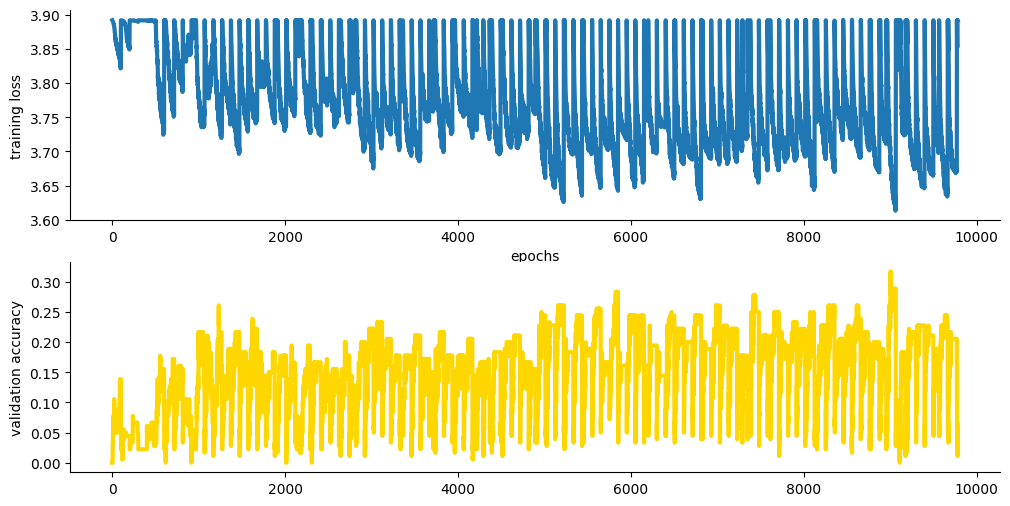

In [116]:
# Import seaborn for prettier plots

import seaborn as sns
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [117]:
# Compute the testing accuracy.
with torch.no_grad(): # Tell PyTorch that we aren't passing inputs to network for training purpose.

    # Pass the testing feature data to the network to produce model predictions.
    y_pred_test = best_model(x_test_final)
    
    # Use the same technique as above to compute the testing classification accuracy.
    # See how many results are correctly classified in the top 3 recommendations. Based on the results, taking the top 3
    # doesn't improve much over the top 1. However, indices 5, 7, etc. seem to contain more correct classifications than
    # 1, 2 for some reason.
    correct = (torch.logical_or(torch.topk(y_pred_test, 10, dim=1).indices[:,0] == y_test_final,
               torch.logical_or(torch.topk(y_pred_test, 10, dim=1).indices[:,1] == y_test_final,
               torch.topk(y_pred_test, 10, dim=1).indices[:,2] == y_test_final))).type(torch.FloatTensor)
    
    # Print test accuracy to the user.
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

    # torch.argmax(y_pred_test, dim=1)

Testing Accuracy: 33.000001311302185%


In [118]:
# Check dimensions of our predicted and actual classes
print(x_test_final.numpy().shape)
print(y_pred_test.numpy().shape)
print(correct.numpy().shape, "\n\n")


predicted_classes = np.array(torch.argmax(y_pred_test, dim=1))
correct_classes = np.array(y_test_final)

# Compare selected predicted and actual classifications
for i in range(len(y_pred_test)):
    print("y_pred_test {}: ".format(i), np.round(np.array(y_pred_test)[i], 2), "\n")
    print("Predicted / Correct species: ", data.at[predicted_classes[i], "Species"], data.at[correct_classes[i], "Species"], "\n\n")

(100, 1)
(100, 49)
(100,) 


y_pred_test 0:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] 

Predicted / Correct species:  CH4N+ 29Si+ 


y_pred_test 1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.] 

Predicted / Correct species:  C4H8N+ C6H5+ 


y_pred_test 2:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] 

Predicted / Correct species:  C+ C+ 


y_pred_test 3:  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.71 0.
 0.   0.   0.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ] 

Predicted / Correct species:  25Mg+ Al+ 


y_pred_test 4:  [0.   0.   0.